In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
# lesson function

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features/255.0

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel1_hist = channel1_hist[0].copy()
    channel1_hist = np.divide(channel1_hist, channel1_hist.sum())
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel2_hist = channel2_hist[0].copy()
    channel2_hist = np.divide(channel2_hist, channel2_hist.sum())
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    channel3_hist = channel3_hist[0].copy()
    channel3_hist = np.divide(channel3_hist, channel3_hist.sum())
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist, channel2_hist, channel3_hist))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, dt, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     print(hog1.shape)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox = []
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                        
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction1 = svc.predict(test_features)
#             test_prediction2 = dt.predict(test_features)
            
            windows.append(((int(xleft*scale), ystart+int(ytop*scale)),\
                            (int((xleft+window)*scale), ystart+int(ytop+window*scale))))
            
#             if test_prediction1 == 1 and test_prediction2 == 1:
            if test_prediction1 == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox, windows

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def filte_draw_labeled_bboxes(img, heat, labels):
    label_box = []
    cars_cnt = 0
    heat_sum = []
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 0, 0)]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        car_size = (bbox[1][0]-bbox[0][0])*(bbox[1][1]-bbox[0][1])
        heat_now = int(heat[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]].sum()/car_size)
#         if car_size>=32*32 and heat_now>5 :
        cars_cnt += 1
        label_box.append((bbox[0], bbox[1]))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], colors[(car_number-1)%len(colors)],6)
        heat_sum.append(heat_now)
    # Return the image
    return img, label_box, cars_cnt, heat_sum

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
dist_pickle = pickle.load( open("svc_pickle_YCrCb_1.p", "rb" ) )
svc = dist_pickle["svc"]
dt = dist_pickle["dt"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [6]:
class Cars:
    def __init__(self):
        self.all_box = []
        self.cars_cnt = 0
        self.label_box = []
        self.frames_cnt = 3
        self.threshold = 10
#         self.scales = [0.8, 1, 1.2, 1.5, 2, 2.5] 
#         self.ystart = [400, 400, 400, 400, 400, 400]
#         self.ystop = [656, 656, 656, 656, 656, 656]
#         self.scales = [0.8, 0.8, 1, 1, 1.5, 1.5, 2, 2, 3.5, 3.5]  
#         self.ystart = [400, 416, 400, 416, 400, 432, 400, 432, 400, 464]
#         self.ystop = [464, 480, 464, 480, 496, 528, 528, 560, 596, 660]
        self.scales = [1, 1, 1.5, 1.5, 1.5, 2, 2, 3, 3]  
        self.ystart = [400, 416, 400, 432, 464, 400, 432, 400, 464]
        self.ystop = [464, 480, 496, 528, 560, 528, 560, 596, 660]

In [7]:

def process_image(image):
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, dt
    global cars
    
    ystart = cars.ystart
    ystop = cars.ystop
    scales = cars.scales
    box_list = []
    windows_list = []
    
    # multiscales
    for i in range(len(scales)):
        out_img, boxs, windows = find_cars(image, ystart[i], ystop[i], scales[i], svc, dt, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list += boxs
        windows_list += windows
#         print(windows)
#         print('--------------------')
        
    if len(cars.all_box)>cars.frames_cnt:
        del cars.all_box[0]
    cars.all_box.append(box_list)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    box_list = []
    for boxs in cars.all_box:
        box_list += boxs
        
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
#     print(heat.sum(),len(np.nonzero(heat)[0]))
#     print("threshold: ", heat.sum()/len(np.nonzero(heat)[0]))
#     if len(np.nonzero(heat)[0])!=0:
#         threshold = heat.sum()/len(np.nonzero(heat)[0])
#         if threshold >2:
#             cars.threshold = int(threshold)
#         else:
#             cars.threshold = 2
#     else:
#         cars.threshold = 2
#     print("cars threshold: ", cars.threshold)
    # Apply threshold to help remove false positives
#     cars.threshold = 1 + len(box_list)//2
    heat = apply_threshold(heat, cars.threshold)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img, label_box, cars_cnt, heat_sum= filte_draw_labeled_bboxes(np.copy(image), heat, labels)
    cars.cars_cnt = cars_cnt
    out_img = draw_boxes(np.copy(image), box_list)
    out_img = draw_boxes(out_img, windows_list, (255,0,0), 1)
#     print(windows_list)
    
     # add little image
    heatmap = heatmap/heatmap.max()*255
    heatmap = heatmap.astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    result = draw_img
    offset = 25
    h,w,_ = image.shape
    h //=3
    w //=3
    little1 = cv2.resize(out_img,(w, h), interpolation = cv2.INTER_AREA)
    little2 = cv2.resize(heatmap,(w, h), interpolation = cv2.INTER_AREA)
    result[:300,:] //= 2 
    result[offset:offset+h, offset:offset+w] = little1
    result[offset:offset+h, 2*offset+w:2*offset+w*2] = little2
    cv2.putText(result, "cars: "+str(cars.cars_cnt), (3*offset+2*w, 50), cv2.FONT_ITALIC, 1, (200,0,0), thickness=3)
    cv2.putText(result, "heat: "+str(heat_sum), (3*offset+2*w, 100), cv2.FONT_ITALIC, 1, (0,200,0), thickness=3)
    cv2.putText(result, "threshold: "+str(cars.threshold), (3*offset+2*w, 150), cv2.FONT_ITALIC, 1, (0,0,200), thickness=3)
#     cv2.putText(result, "r_basex: "+"{:.2f}".format(line.rightx_current*xm_per_pix)+"m", (3*offset+2*w, 200), cv2.FONT_ITALIC, 1, (0,200,0), thickness=3)
    
#     cv2.putText(result, "center: "+"{:.2f}".format((line.rightx_current+line.leftx_current-1280)/2.0*xm_per_pix)+"m", (3*offset+2*w, 250), cv2.FONT_ITALIC, 1, (0,200,0), thickness=3)

    return result



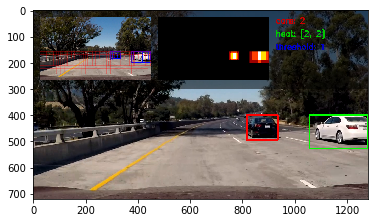

In [8]:
# Read in image similar to one shown above 
# image = mpimg.imread('test_images/test1.jpg')

clip1 = VideoFileClip("project_video.mp4").subclip(41,42)
frame_index = 10
image = clip1.get_frame(frame_index)

cars = Cars()
cars.threshold = 1
out_img = process_image(image)
plt.figure()
plt.imshow(out_img)
plt.savefig("output_images/pipeline.jpg", bbox_inches='tight', pad_inches=0)

In [9]:
cars = Cars()
# cars.threshold = 2
# cars.frames_cnt = 10
cars.threshold = 10
cars.frames_cnt = 10
white_output = 'test_videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4").subclip(27,30)
# frame_index = 100
# image = clip1.get_frame(frame_index)
# len([frame for frame in clip1.iter_frames()])
     
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

# plt.imshow(process_image(image))


[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [19:12<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 38min 37s, sys: 42.1 s, total: 39min 19s
Wall time: 19min 13s


In [10]:
cars = Cars()
# cars.threshold = 2
# cars.frames_cnt = 10
cars.threshold = 10
cars.frames_cnt = 10
white_output = 'test_videos_output/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
# clip1 = VideoFileClip("project_video.mp4").subclip(27,30)
# frame_index = 100
# image = clip1.get_frame(frame_index)
# len([frame for frame in clip1.iter_frames()])
     
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

# plt.imshow(process_image(image))


[MoviePy] >>>> Building video test_videos_output/challenge_video_output.mp4
[MoviePy] Writing video test_videos_output/challenge_video_output.mp4


100%|██████████| 485/485 [07:17<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_output.mp4 

CPU times: user 14min 39s, sys: 16.1 s, total: 14min 55s
Wall time: 7min 18s


In [11]:
cars = Cars()
cars.threshold = 10
cars.frames_cnt = 10
white_output = 'test_videos_output/test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
     
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

# plt.imshow(process_image(image))

[MoviePy] >>>> Building video test_videos_output/test_video_output.mp4
[MoviePy] Writing video test_videos_output/test_video_output.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video_output.mp4 

CPU times: user 1min 11s, sys: 1.22 s, total: 1min 12s
Wall time: 36.6 s
